# Paper title: Geometric properties of PalmTree instruction embeddings
## Target IJCNN, deadline: End of January


## **Overview**
*   Geometry of embeddings
*   Pairwise correlations
*   Find which are closer to which 
*   Analog relationship or outlier detection, see how embeddings relate different instructions
*   Analyze how effective basic block search is
*   Improve it by encoding pairs, or more instructions at a time
*   Do deep metric learning to improve distance matching/basic block search \

**Pairwise correlations** 
*   Correlations of the embeddings, plot them on histogram 
*   Relies on inner products between two vectors,

**Analyze** 
*   call, ret, mov, etc. most important instructions in malware analysis
*   Pick common instructions, look at embeddings see which ones are closer
*   Prediction "non of embeddings will be close/ will be perpendicular" 
*   Look at the vectors, for constants 0, 1, 2, etc. 

**Analog query** 
*   K nearest neighbors  
*   Look at vectors in  each layer, as input goes through, can see performance for analog query 
*   Find vector for king, minus vector for man + woman. find vector closest to this, see if result vector is close to king 
*   Outlier detection, look at each layer 

**Plot of embedding norms** 
*   Norm inverserly related to the frequency of tokens 
*   The most frequent tokens had smallest norm in Bert 

**For outliers, see accuracy of outliers from layer to layer**
*   Given sequence, see how it changes through the layers 
*   Look at number of layers in model 

**Basic Block Search** 
*   Do analysis, how effective the embeddings to characterize similiarities between basic blocks 
*   Average cosine distance used as similarity 

**Possible improvment**
*   Given a basic block, if encodes one instruction at time, then take average
*   Problem for instructions that are dependant on others
*   Figure out how to improve it, possible encod epair of instructions at a time

**Metric learning** "Deep Metric Learning to Rank"
*   If dataset is available, apply FastAP
*   See if it improves 







## Initialize Colab & Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install bert-pytorch

In [3]:
cd /content/drive/MyDrive/Colab \Notebooks/PalmTree-Trained/

/content/drive/.shortcut-targets-by-id/1LMg3kN9NvUURy3zB07RjiMQNzN0TPyMm/PalmTree-Trained


## Imports

In [4]:
from config import *
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.neighbors import KernelDensity
from torch.autograd import Variable
from sklearn import preprocessing
from scipy import spatial

import matplotlib.pyplot as plt
import eval_utils as utils
import numpy as np
import pandas as pd

import os
import torch
import vocab
import pickle



## Defined Methods

In [5]:
def Distance_Distributions_all(example_index, example_group, unary_group, instruction_groups):

  ex_group = palmtree.encode(example_group)
  un_group = palmtree.encode(unary_group)
  ex = ex_group[example_index]

  same_group_dist = []
  unary_group_dist = []
  diff_group_dist = []

  combined_hist = []

  for j in range(0,len(ex_group)):
    #temp = ex - ex_group[j]
    #sum_sq = np.dot(temp.T, temp)
    #dist = np.sqrt(sum_sq)
    dist = np.linalg.norm(ex-ex_group[j])

    same_group_dist.append(dist)


  for j in range(0,len(un_group)):
    #temp = ex - un_group[j]
    #sum_sq = np.dot(temp.T, temp)
    #dist = np.sqrt(sum_sq)
    dist = np.linalg.norm(ex-un_group[j])
    unary_group_dist.append(dist)

  for g in instruction_groups:
      if g == "MOV" or instruction_groups[g] == example_group:
        continue

      print("Encoding group:", g)
      g_emb = palmtree.encode(instruction_groups[g])
      print("Finished encoding group: ", g)

      group_distance = {g:[]}

      for k in range(0,len(g_emb)):
        #temp = ex - g_emb[k]
        #sum_sq = np.dot(temp.T, temp)
        #dist = np.sqrt(sum_sq)
        dist = np.linalg.norm(ex-g_emb[k])


        #temp = (Ex - emb[0]).T
        #temp.T dot temp  



        group_distance[g].append(dist)
      combined_hist.extend(group_distance[g])

      #print(group_distance)
  #print(len(combined_hist))

  return same_group_dist, unary_group_dist, combined_hist

In [6]:
def Cosine_Similarity_all(example_index, example_group, unary_group, instruction_groups):
  ex_group = palmtree.encode(example_group)
  un_group = palmtree.encode(unary_group)
  ex = ex_group[example_index]

  same_group_dist = []
  unary_group_dist = []
  diff_group_dist = []

  combined_hist = []

  for j in range(0,len(ex_group)):
    cosin = 1 - spatial.distance.cosine(ex, ex_group[j])
    same_group_dist.append(cosin)


  for j in range(0,len(un_group)):
    cosin = 1 - spatial.distance.cosine(ex, un_group[j])
    unary_group_dist.append(cosin)

  for g in instruction_groups:
      if g == "MOV" or instruction_groups[g] == example_group:
        continue

      print("Encoding group:", g)
      g_emb = palmtree.encode(instruction_groups[g])
      print("Finished encoding group: ", g)

      group_distance = {g:[]}

      for k in range(0,len(g_emb)):
        cosin = 1 - spatial.distance.cosine(ex, g_emb[k])

        group_distance[g].append(cosin)
      combined_hist.extend(group_distance[g])
  return same_group_dist, unary_group_dist, combined_hist

## Load PalmTree Model

In [7]:
palmtree = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")

Loading Vocab ./palmtree/vocab
Vocab Size:  6631


## Datasets Used for Intrinsic Evaluation

In [8]:
ground_truth_file = "intrinsic_eval/opcode.pkl"
with open(ground_truth_file, 'rb') as f:
    instruction_set = pickle.load(f)

type(instruction_set)
num_of_ins = 0
for ins in instruction_set:
  instruction_set[ins] = list(instruction_set[ins])
  print(ins, len(instruction_set[ins]) ,instruction_set[ins])
  num_of_ins += len(instruction_set[ins])
print('number of instructions:' , num_of_ins)


MOV 4206 ['mov,ecx,dword [ rbp - 0x308 ]', 'mov,rdx,qword [ rsp + 0x60 ]', 'mov,dword [ ebp - 0x20 ],0x1', 'mov,r9,qword [ r8 + 0x10 ]', 'mov,byte [ rax ],0x1', 'mov,rbx,qword [ rbp - 0x328 ]', 'mov,byte [ rsp + 0x15 ],0x1', 'mov,rcx,qword [ rsp + 0x58 ]', 'mov,qword [ r12 + 0x18 ],0x0', 'mov,ebx,dword [ ebp - 0x50 ]', 'mov,ecx,dword [ ecx ]', 'mov,r13,qword [ rcx + 0x60 ]', 'push,rbx', 'mov,r13,qword [ r15 ]', 'mov,r13,qword [ rsp + 0x20 ]', 'pop,rbx', 'mov,rax,qword [ rbp - 0x350 ]', 'mov,dword [ esp ],0x1', 'mov,rbp,rcx', 'mov,edx,0xa', 'mov,edx,dword [ rbx + 0x10 ]', 'mov,dword [ ebp + 0x8 ],0x1', 'mov,dword [ ebx + 0x10 ],0x0', 'mov,byte [ rbp - 0x338 ],0x0', 'mov,qword [ rbp - 0x358 ],rcx', 'mov,dword [ rbp - 0x320 ],r8d', 'mov,byte [ rbx + 0x19 ],al', 'push,dword [ ebp - 0x30 ]', 'mov,qword [ r12 + 0x38 ],0x0', 'mov,dword [ edx ],ecx', 'mov,dword [ esp ],edx', 'mov,rax,qword [ rsp + 0x90 ]', 'mov,ebx,0x73', 'mov,rcx,qword [ rsp + 0x38 ]', 'mov,dword [ esp + 0x4 ],edi', 'mov,rsi,

In [9]:
binop_set = instruction_set['BINOP']
unary_set = instruction_set['UNARY']

try:
  ex_i = binop_set.index("or,al,dl") 
except ValueError:
  ex_i = 0

In [10]:
same_group, unary_group, diff_group = Distance_Distributions_all(ex_i, binop_set, unary_set, instruction_set)

Encoding group: CALL
Finished encoding group:  CALL
Encoding group: CMP
Finished encoding group:  CMP
Encoding group: JMP
Finished encoding group:  JMP
Encoding group: SHIFT
Finished encoding group:  SHIFT
Encoding group: CSET
Finished encoding group:  CSET
Encoding group: CMOV
Finished encoding group:  CMOV
Encoding group: UNARY
Finished encoding group:  UNARY
Encoding group: FP
Finished encoding group:  FP


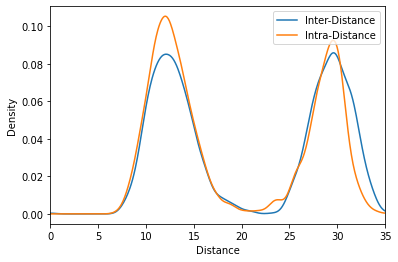

In [11]:
df1 = pd.DataFrame({'Inter-Distance' : same_group})
df2 = pd.DataFrame({'Intra-Distance' : diff_group})

fig, ax = plt.subplots()
plt.xlim(0, 35)
plt.xlabel("Distance")

df1.plot.kde(bw_method=0.07, ax=ax)
df2.plot.kde(bw_method=0.07, ax=ax)


### Cosine Similarity

In [13]:
same_group, unary_group, diff_group = Cosine_Similarity_all(ex_i, binop_set, unary_set, instruction_set)

Encoding group: CALL
Finished encoding group:  CALL
Encoding group: CMP
Finished encoding group:  CMP
Encoding group: JMP
Finished encoding group:  JMP
Encoding group: SHIFT
Finished encoding group:  SHIFT
Encoding group: CSET
Finished encoding group:  CSET
Encoding group: CMOV
Finished encoding group:  CMOV
Encoding group: UNARY
Finished encoding group:  UNARY
Encoding group: FP
Finished encoding group:  FP


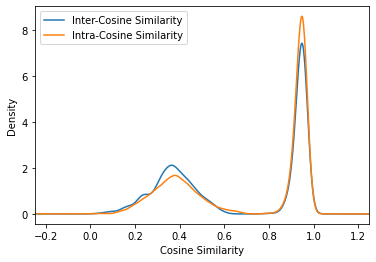

In [14]:
df1 = pd.DataFrame({'Inter-Cosine Similarity': same_group})
df2 = pd.DataFrame({'Intra-Cosine Similarity': diff_group})

fig, ax = plt.subplots()
plt.xlim(-0.25, 1.25)
plt.xlabel("Cosine Similarity")

df1.plot.kde(bw_method=0.07, ax=ax)
df2.plot.kde(bw_method=0.07, ax=ax)

In [15]:
print(len(diff_group))
print(len(same_group))

1754
1743


## Old Code

In [ ]:
'''
out1 = instruction_set['SHIFT']
out2 = instruction_set['CMOV']

ex_i = 0

out1_emb = palmtree.encode(out1)
out2_emb = palmtree.encode(out2)

Distance_Distributions(out1_emb, out2_emb, ex_i)

out1 = instruction_set['CALL']
out2 = instruction_set['UNARY']

try:
  ex_i = out1.index("call,rax") 
except ValueError:
  ex_i = 0

out1_emb = palmtree.encode(out1)
out2_emb = palmtree.encode(out2)
Distance_Distributions(out1_emb, out2_emb, ex_i)
'''

'\nout1 = instruction_set[\'SHIFT\']\nout2 = instruction_set[\'CMOV\']\n\nex_i = 0\n\nout1_emb = palmtree.encode(out1)\nout2_emb = palmtree.encode(out2)\n\nDistance_Distributions(out1_emb, out2_emb, ex_i)\n\nout1 = instruction_set[\'CALL\']\nout2 = instruction_set[\'UNARY\']\n\ntry:\n  ex_i = out1.index("call,rax") \nexcept ValueError:\n  ex_i = 0\n\nout1_emb = palmtree.encode(out1)\nout2_emb = palmtree.encode(out2)\nDistance_Distributions(out1_emb, out2_emb, ex_i)\n'

In [ ]:
'''
def Distance_Distributions(group1, group2, example_index):

  ex = group1[example_index]

  same_group_dist = []
  diff_group_dist = []

  for j in range(0,len(group1)):
    temp = ex - group1[j]
    sum_sq = np.dot(temp.T, temp)
    dist = np.sqrt(sum_sq)

    same_group_dist.append(dist)

  for j in range(0,len(group2)):
    temp = ex - group2[j]
    sum_sq = np.dot(temp.T, temp)
    dist = np.sqrt(sum_sq)

    diff_group_dist.append(dist)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)
  #fig.grid(visible=True)
  ax1.plot(same_group_dist, color="b", label="in_family")
  ax1.set_title("In Family Distributions")
  ax1.grid()

  ax2.plot(diff_group_dist, color="r", label="diff_family")
  ax2.set_title("Different Family Distributions")
  ax2.grid()

  fig.legend()



fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(16, 4))

X = np.array(same_group)
X = np.reshape(X, (-1, 1))
X_plot = np.linspace(5, 35, len(same_group))[:, np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.65).fit(X)
x_logs = kde.score_samples(X_plot)

ax1.fill(X_plot, np.exp(x_logs))
ax1.set_title("Inter-Family Embeddings Distribution")

X = np.array(diff_group)
X = np.reshape(X, (-1, 1))
X_plot = np.linspace(5, 35, len(diff_group))[:, np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.65).fit(X)
x_logs = kde.score_samples(X_plot)

ax2.fill(X_plot, np.exp(x_logs))
ax2.set_title("Intra-Family Embeddings Distribution")

ax1.set(xlabel="Distance")
ax2.set(xlabel="Distance")


fig.savefig('Embedding Distribuitions.pdf')  


fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(16, 4))
X = np.array(same_group)
X = np.reshape(X, (-1, 1))
X_plot = np.linspace(5, 35, len(same_group))[:, np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.14).fit(X)
x_logs = kde.score_samples(X_plot)

ax1.fill(X_plot, np.exp(x_logs))
ax1.set_title("Inter-Family Embeddings Distribution")

X = np.array(unary_group)
X = np.reshape(X, (-1, 1))
X_plot = np.linspace(5, 35, len(unary_group))[:, np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.65).fit(X)
x_logs = kde.score_samples(X_plot)

ax2.fill(X_plot, np.exp(x_logs))
ax2.set_title("Unary Embeddings Distribution")

ax1.set(xlabel="Distance")
ax2.set(xlabel="Distance")

'''

'\ndef Distance_Distributions(group1, group2, example_index):\n\n  ex = group1[example_index]\n\n  same_group_dist = []\n  diff_group_dist = []\n\n  for j in range(0,len(group1)):\n    temp = ex - group1[j]\n    sum_sq = np.dot(temp.T, temp)\n    dist = np.sqrt(sum_sq)\n\n    same_group_dist.append(dist)\n\n  for j in range(0,len(group2)):\n    temp = ex - group2[j]\n    sum_sq = np.dot(temp.T, temp)\n    dist = np.sqrt(sum_sq)\n\n    diff_group_dist.append(dist)\n\n  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)\n  #fig.grid(visible=True)\n  ax1.plot(same_group_dist, color="b", label="in_family")\n  ax1.set_title("In Family Distributions")\n  ax1.grid()\n\n  ax2.plot(diff_group_dist, color="r", label="diff_family")\n  ax2.set_title("Different Family Distributions")\n  ax2.grid()\n\n  fig.legend()\n\n\n\nfig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(16, 4))\n\nX = np.array(same_group)\nX = np.reshape(X, (-1, 1))\nX_plot = np.linspace(5, 35

# Further Readings & References

**Papers to read**
*   Neutron: https://cybersecurity.springeropen.com/articles/10.1186/s42400-021-00070-0
*   Geometry of Bert: http://vigir.missouri.edu/~gdesouza/Research/Conference_CDs/IEEE_WCCI_2020/IJCNN/Papers/N-21493.pdf
* PalmTree: https://arxiv.org/pdf/2103.03809.pdf
* Blanket Execution: https://www.usenix.org/system/files/conference/usenixsecurity14/sec14-paper-egele.pdf 